In [1]:
import h5py
import numpy as np
import display
import dereference
from importlib import reload
import tqdm
from matplotlib import pyplot as plt
import os
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.cluster import DBSCAN
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import yaml
import numpy as np
import argparse
import json
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import Normalize
from collections import defaultdict
import pickle
import scipy


###
# Some useful geometry functions and channel <-->
def _default_pxy():
    return (0., 0.)

def _rotate_pixel(pixel_pos, tile_orientation):
    return pixel_pos[0]*tile_orientation[2], pixel_pos[1]*tile_orientation[1]

def unique_channel_id( packets  ):
    iog_tile_id = ((packets['io_channel']-1) // 4) + 1
    tile_offset = 10 * (packets['io_group']-1)
    tile_id = iog_tile_id + tile_offset # runs through 1-64 in 2x2, 1-40 in FSD
    unique_id = (packets['io_group'].astype(int)*1000_000_000
                 + tile_id.astype(int)*100_000
                 + packets['chip_id'].astype(int)*100
                 + packets['channel_id'].astype(int))
    
    return unique_id

def unique_to_channel_id(unique):
    return unique % 100

def unique_to_chip_id(unique):
    return (unique // 100) % 1000

def unique_to_io_channel(unique):
    return (unique//(100*1000)) % 1000

def unique_to_tiles(unique):
    return ((unique_to_io_channel(unique)-1) // 4) + 1

def unique_to_io_group(unique):
    return (unique // (100*1000*1000)) % 1000


In [2]:
def get_event_trigs(f, ev):
    ref = f['charge/events/ref/charge/ext_trigs/ref']
    return dereference.dereference( ev, ref, f['charge/ext_trigs/data'] )
    
def normalize(v):
    return v/np.sqrt(np.sum(v**2))
    
all_distances=[]

def process_hits(hhits, scale=1, min_hit=200):
    normals, center_points = [], []
    if hhits.shape[0] < 20: return [],[], []
    # remove hits with extraneous drift or low Q
    all_hits = hhits #[np.logical_and( hhits['Q']>0, hhits['t_drift'] < 3200)]
    Q = all_hits['Q']

    bounds =[[-50, 50.], [-154., 154.], [-50.,  50.]]
    
    # go one TPC at a time
    if True:
    
        ppoints = np.array( [all_hits['x']*scale, all_hits['y']*scale, all_hits['z']*scale]).transpose()
        
        #cluster points
        db = DBSCAN(eps=2.5, min_samples=10).fit(ppoints)
        
        #perform analysis on clusters with > 500 hits
        
        un, counts = np.unique( db.labels_ , return_counts=True)
        
        #take the largest cluster only
        u = un[ np.argmax(counts) ]
        if np.sum(u)<20: [],[], []
        if True:
        #for u in un[ counts > min_hit]:

            points = ppoints[ np.logical_and(db.labels_==u, Q > 40 ) ]
            # reject events where a clear direction can't be established
            pca=PCA(n_components=3)
            if points.shape[0]<20: return [],[],[]
            pca.fit(points)
            if np.max(pca.explained_variance_ratio_) < 0.9: return [],[],[]
            #if np.max(pca.explained_variance_ratio_) > 0.998: continue
            #if np.max(hits['Q']) < 30: continue
        
            # Centering the points
            mean_point = np.mean(points, axis=0)
            centered_points = points - mean_point

            # Calculating the covariance matrix
            covariance_matrix = np.cov(centered_points, rowvar=False)

            # Performing the SVD
            U, s, V = np.linalg.svd(covariance_matrix)

            # Getting the first column of the first matrix U as the best fit line
            normal = normalize(U[:, 0])
            
            normals.append(normal)
            center_points.append(mean_point)
        
            #calculate the closest distance to the fit line for each hit.
            #Ensure good fit with cut on mean squared distance
            
            projection_on_fit = centered_points[:,0] * normal[0] + centered_points[:,1] * normal[1] + centered_points[:,2] * normal[2]
            perp_vec = centered_points - np.array([projection_on_fit]).transpose() @ np.array([normal])
            
            perp_distance = np.sqrt(np.sum( perp_vec**2, axis=1 ))

            if np.mean(perp_distance) > 2.0: return [],[],[]
            
    return normals, center_points, db.labels_==u 
            

In [3]:

def asymmetry(hits, center_point, normal, hit_threshold=9999):
    
    ath = hits[ np.logical_and(hits['Q'] > 16, hits['Q'] < hit_threshold )]
    # get threshold x position as a function of y. subtract off center point to make calculations nice
    
    x0 = ath['x']
    hx, hy, hz, hq = ath['x']-center_point[0], ath['y']-center_point[1], ath['z']-center_point[2], ath['Q']
    
    t2 = hy / normal[1]
    t = hz / normal[2]
    
    x =  normal[0] * t #( normal[1] * hy + normal[2] * hz ) / ( - normal[0] )
    #z=normal[2]*t2
    # find hits on the anode size of the drift
    mask = np.logical_or (   np.logical_and( hx < x, x0 < 0), np.logical_and(hx > x, x0 > 0) )
    nmask = np.logical_or (   np.logical_and( hx > x, x0 < 0), np.logical_and(hx < x,x0 > 0) )

    # To test, find hits on top or bottom z side
    #mask = hz < z
    #nmask = hz > z
    
    #
    Q_A = np.sum(hq[mask])
    Q_C = np.sum(hq[nmask])
    
    N_A = np.sum(mask)
    N_C = np.sum(nmask)

    return np.sum(hits['Q'][hits['Q']>0]), (Q_A - Q_C) / (Q_A + Q_C), hits.shape[0], (N_A - N_C)/(N_A+N_C), ath[mask], ath[nmask]
    

In [4]:
reload(display)


<module 'display' from '/global/u2/s/sgberg/ndproto_develop/jupyter/fsd/complete_fsd_performance_studies/shower_asymm/display.py'>

In [5]:
def analyze_file(f, min_nhit=2000):
    sumqs, q_asymms, nhits, nhit_asymms = [],[],[],[]
    evs = f['charge/events/data']['id'][ f['charge/events/data']['nhit'] > min_nhit ]
    for ev in tqdm.tqdm(evs):
        sumq, q_asymm, nhit, nhit_asymm = analyze_single_event(f,ev)
        
        if sumq is None: continue
        sumqs.append(sumq)
        q_asymms.append(q_asymm)
        nhits.append(nhit)
        nhit_asymms.append(nhit_asymm)
   
    return {'sumqs' : sumqs, 
            'q_asymms' : q_asymms, 
            'nhits' : nhits, 
            'nhit_asymms' : nhit_asymms
           }
    
from matplotlib import colors

def analyze_single_event(f, ev, plot=False):
    if True:
        if True:
            hits, packets = dereference.get_event_hits_packets(f, ev)
            norms, cents, labs = process_hits(hits)
            
            assym_label_format='Total energy: {:0.3f} GeV\nQ asymm: {:0.2f}\nNhit asymm: {:0.2f}'
            asymm_lab=None
            if len(norms)==0: return None, None, None, None
            hhits=hits[labs]
            for i in range(len(norms)):
                sumq, q_asymm, nhit, nhit_asymm, hm, hn = asymmetry(hhits, cents[i], norms[i], hit_threshold=99999)
                sumq = np.sum(hits['Q']) * 50 / 10**9 * 1e3
                nhit=hits.shape[0]
                assym_lab = assym_label_format.format( sumq, q_asymm, nhit_asymm )
            
            
            if plot:
                display.display_cluster_legend(hits, clusters=labs)
                
                fig=plt.figure(figsize=(14, 5))

                ax = fig.add_subplot(1, 3, 1, projection='3d')
                sc=ax.scatter(hits[labs]['z'], hits[labs]['y'], hits[labs]['x'], c=hits[labs]['Q'], s=(1+np.log(hits[labs]['Q']))/20, label='all hits', cmap='viridis', vmin=12)
                plt.colorbar(sc, ax=ax, label='hit charge [ke-]', location='bottom', fraction=0.05)
                plt.xlabel('z [cm]')
                plt.ylabel('y [cm]')

                ax2 = fig.add_subplot(1, 3, 2)
                mask= np.logical_and(hits['Q']<12, labs)
                #plt.scatter(hits[mask]['y'], hits[mask]['x'], c=hits[mask]['Q'], marker='.', s=8)
                plt.scatter(hits[mask]['y'], hits[mask]['x'], c='red', marker='.', s=1, label='threshold hits')

                mask= np.logical_and(hits['Q']>45, labs)
                plt.scatter(hits[mask]['y'], hits[mask]['x'], c=hits[mask]['Q'], marker='.', s=5, label='high ionization')

                plt.xlabel('y [cm]', fontsize=12)
                plt.ylabel('x [cm]', fontsize=12, labelpad=0)
                #plt.ylabel('x [cm]', fontsize=12)
                plt.suptitle('{}\nEvent {}'.format(fname, ev))
                plt_x=np.linspace(-80, 100, 1000)
                for i in range(len(norms)):
                    line_x = cents[i][0] + norms[i][0]*plt_x
                    line_y = cents[i][1] + norms[i][1]*plt_x
                    plt.plot( line_y, line_x, label='midline fit', linewidth=1.5, linestyle='--', alpha=0.65)
                plt.legend(fontsize=12, markerscale=3)
                plt.grid()

                ax3 = fig.add_subplot(1, 3, 3)
                mask= np.logical_and(hits['Q']<12, labs)
                #plt.scatter(hits[mask]['y'], hits[mask]['x'], c=hits[mask]['Q'], marker='.', s=8)
                plt.scatter(hits[mask]['z'], hits[mask]['x'], c='red', marker='.', s=1)
                mask= np.logical_and(hits['Q']>45, labs)
                plt.scatter(hits[mask]['z'], hits[mask]['x'], c=hits[mask]['Q'], marker='.', s=10)

                plt.xlabel('z [cm]', fontsize=12)
                
                plt_x=np.linspace(-40, 40, 900)

                for i in range(len(norms)):
                    line_x = cents[i][0] + norms[i][0]*plt_x
                    line_y = cents[i][2] + norms[i][2]*plt_x
                    plt.plot( line_y, line_x, label='midline fit', linewidth=1.5, linestyle='--', alpha=0.65)
                    #plt.scatter(line_y, line_x, label=asymm_lab, marker='.', s=1)
                
                plt.grid()

                fig = plt.figure()
                ax=fig.add_subplot()
                for i in range(len(norms)):
                    line_x = cents[i][0] + norms[i][0]*plt_x
                    line_y = cents[i][2] + norms[i][2]*plt_x
                    
                    plt.plot( line_y, line_x, linewidth=2, alpha=0.8, color='red', label='shower core fit')

                plt.scatter(hm['z'], hm['x'], marker='.', label='cathode-side')
                plt.scatter(hn['z'], hn['x'], marker='.', label='anode-side')
                ax.axhline(50.5, color='black', label='cathode')
                ax.axhline(0, color='green', label='anode')
                plt.legend(fontsize=12)
                plt.grid()
                plt.xlabel('hit z [cm]', fontsize=12)
                plt.ylabel('hit x [cm]', fontsize=12)
                
                ax3.set_yticklabels([])
                pos1 = ax2.get_position()  # Get the original position
                pos2 = ax3.get_position()
                gap = pos2.x0 - pos1.x1     # Calculate the gap between the subplots
                ax3.set_position([pos2.x0 - gap, pos2.y0, pos2.width, pos2.height])
                
    return sumq, q_asymm, nhit, nhit_asymm

In [6]:
d='/global/cfs/projectdirs/dune/www/data/FSD/reflows/v4/flow/cosmics/08Nov2024/'
files = [f for f in os.listdir(d) if '0020114' in f]

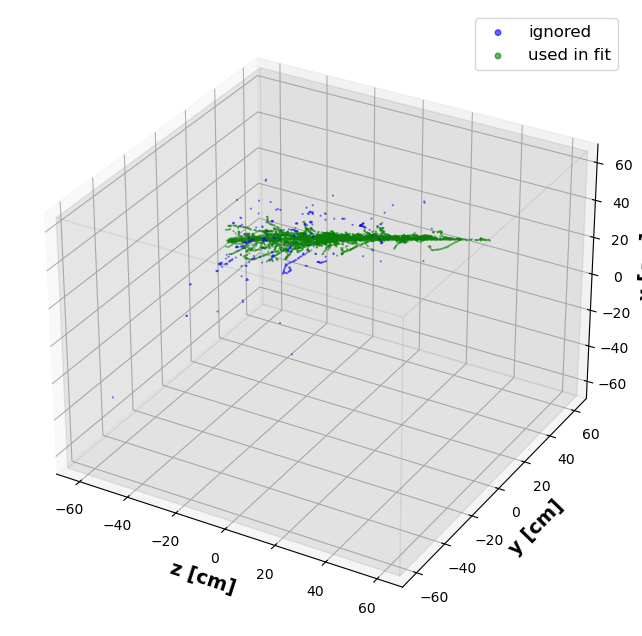

0.05759660490751479


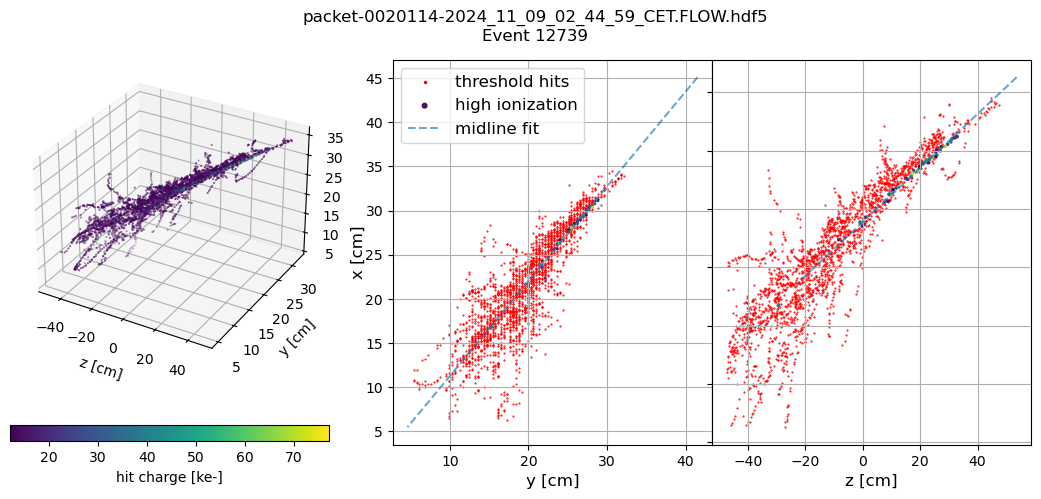

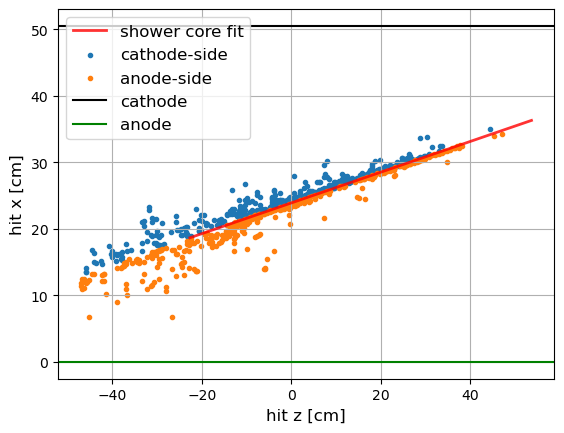

In [7]:
# Display a few example events and 
# - draw clustering
# - draw fit and hits on either side

f=h5py.File(d+files[1])
fname=files[1]

evs = f['charge/events/data']['id'][ f['charge/events/data']['nhit'] > 2000 ]

ev=evs[5]

w, x, y, z = analyze_single_event(f, ev, plot=True)
print(x)

In [8]:
data_store_nominal = {

        'sumqs': [], 
        'q_asymms' : [],
        'nhits' : [], 
        'nhit_asymms' : []
        }
#

import gc

def close_all_h5_files():
    for obj in gc.get_objects():   # Browse through ALL objects
        if isinstance(obj, h5py.File):   # Just HDF5 files
            try:
                obj.close()
            except:
                pass # Was already closed

def create_h5_file_safe(file_name, data_format=data_store_nominal.keys()):
    '''Create an HDF5 file, don't overwrite if the file already exists'''
    if os.path.isfile(file_name):
        print('Not creating file, already exists!')
        return

    with h5py.File(file_name, "w") as f:
        for key in data_format:
            f.create_dataset(key, data=np.array([]), compression="gzip", maxshape=(None,))

    return

In [9]:
# main loop to analyze files
close_all_h5_files()

if True:
    ddir='/global/cfs/projectdirs/dune/www/data/FSD/reflows/v4/flow/cosmics/08Nov2024/'
    all_files=sorted(os.listdir(ddir))
    print('Found {} files'.format(len(all_files)))

    data_file_name = 'FSD_ASYMM_NAME_ME.h5'
    create_h5_file_safe(data_file_name)

    print('Data file ready to write!')
    
    for file in all_files[0:10]:
        f=h5py.File(ddir+file)
        dstore = analyze_file(f)

        # save data from dstore
        with h5py.File(data_file_name, 'a') as hf:
            for key in dstore.keys():
                d=np.array(dstore[key])
                orig_size = hf[key].shape[0]
                hf[key].resize(( orig_size + d.shape[0]), axis = 0)
                hf[key][-d.shape[0]:] = d


Found 294 files
Data file ready to write!


100%|██████████| 36/36 [00:05<00:00,  6.47it/s]


In [10]:
# Load data file objects into memory for analysis
fdata=h5py.File(data_file_name)
sumqs = fdata['sumqs'][:]
q_asymms = fdata['q_asymms'][:]
nhits = fdata['nhits'][:]
nhit_asymms = fdata['nhit_asymms'][:]
fdata.close()

Text(0, 0.5, 'event counts')

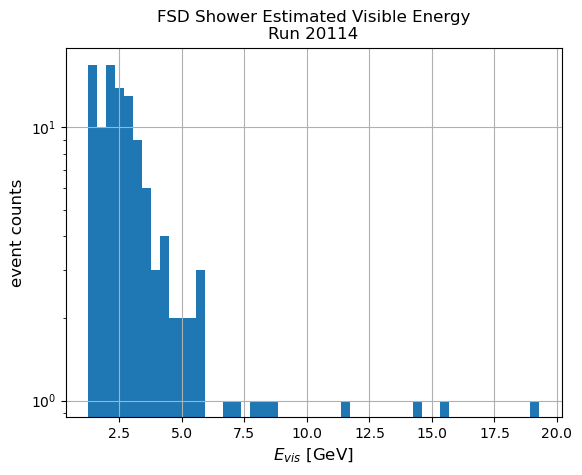

In [11]:
fig=plt.figure()
ax=fig.add_subplot()
ax.hist(sumqs, bins=50)
ax.set_xlabel('$E_{vis}$ [GeV]', fontsize=12)
ax.set_yscale('log')
ax.grid()
ax.set_title('FSD Shower Estimated Visible Energy\nRun 20114')
ax.set_ylabel('event counts', fontsize=12)

/tmp/ipykernel_196844/2929166101.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 20)


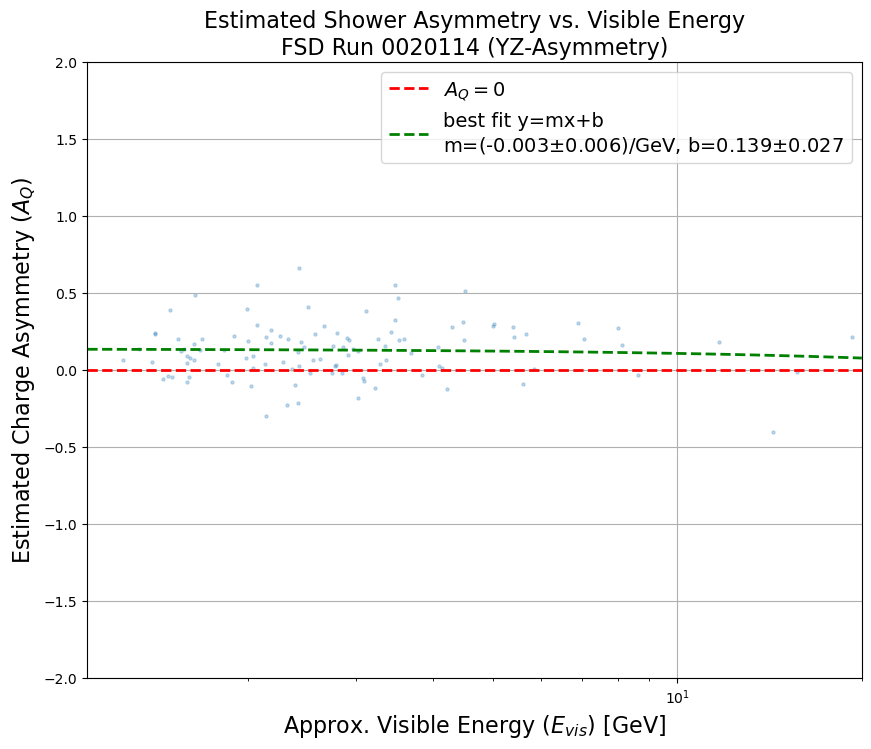

In [12]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot()
plt.scatter(np.array(sumqs), q_asymms, s=5, alpha=0.25)
plt.xscale('log')
plt.ylim(-2, 2)
plt.xlim(0, 20)
ax.axhline(0, color='red', linestyle='--', label='$A_{Q}=0$', linewidth=2)

ax.grid()
ax.set_xlabel('Approx. Visible Energy ($E_{vis}$) [GeV]', fontsize=16)
ax.set_ylabel('Estimated Charge Asymmetry ($A_Q$)', fontsize=16)
ax.set_title('Estimated Shower Asymmetry vs. Visible Energy\nFSD Run 0020114 (YZ-Asymmetry)', fontsize=16)

from scipy.optimize import curve_fit

def line(x, A, B):
    return A*x + B

x = np.linspace(0, 20, 100)

params, pcov = curve_fit(line, np.array(sumqs), q_asymms)

ax.plot( x, line(x, *params), linestyle='--', color='green', linewidth=2,\
        label='best fit y=mx+b\nm=({:0.3f}$\pm${:0.3f})/GeV, b={:0.3f}$\pm${:0.3f}'.format(params[0], np.sqrt(pcov[0][0]), params[1], np.sqrt(pcov[1][1]))  )
ax.legend(fontsize=14)

30


Text(0, 0.5, 'density')

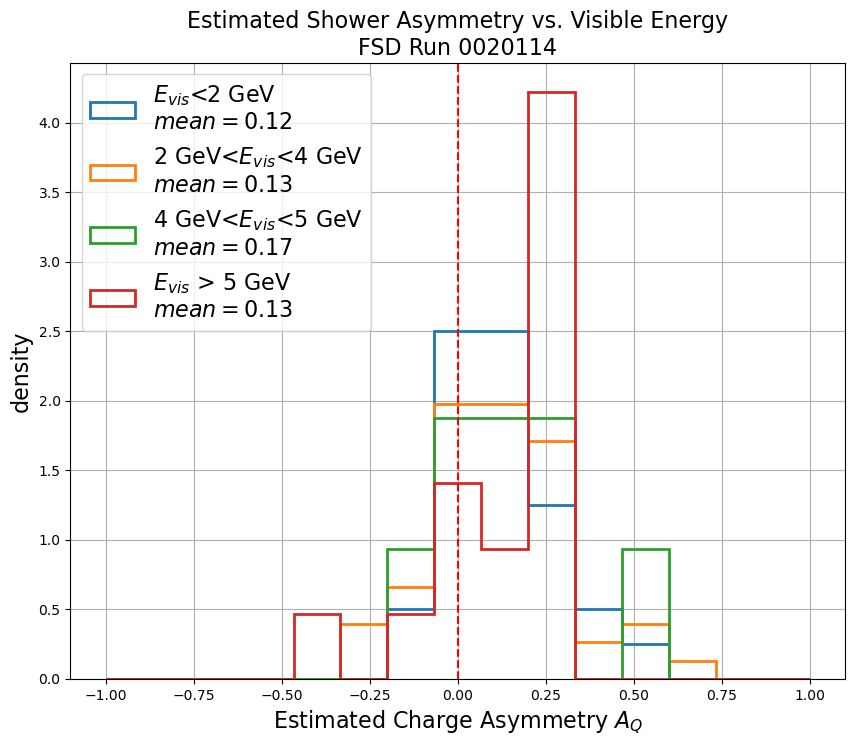

In [13]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot()

m = np.array(sumqs) < 2
print(np.sum(m))
plt.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), density=True, histtype='step', label='$E_{vis}$<2 GeV'+'\n$mean={:0.2f}$'.format(np.mean(np.array(q_asymms)[m])), linewidth=2)

m = np.logical_and(np.array(sumqs) > 2, np.array(sumqs) < 4 ) 
plt.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), density=True, histtype='step', label='2 GeV<$E_{vis}$<4 GeV'+'\n$mean={:0.2f}$'.format(np.mean(np.array(q_asymms)[m])), linewidth=2)


m = np.logical_and(np.array(sumqs) > 4, np.array(sumqs) < 5 ) 
plt.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), density=True, histtype='step', label='4 GeV<$E_{vis}$<5 GeV'+'\n$mean={:0.2f}$'.format(np.mean(np.array(q_asymms)[m])), linewidth=2)

m = np.logical_and(np.array(sumqs) > 5, np.array(sumqs) > 5) 
plt.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), density=True, histtype='step', label='$E_{vis}$ > 5 GeV'+'\n$mean={:0.2f}$'.format(np.mean(np.array(q_asymms)[m])), linewidth=2)




ax.axvline(0, color='red', linestyle='--')
plt.grid()
#plt.yscale('log')
plt.legend(fontsize=16)
ax.set_title('Estimated Shower Asymmetry vs. Visible Energy\nFSD Run 0020114', fontsize=16)
ax.set_xlabel('Estimated Charge Asymmetry $A_Q$', fontsize=16)
ax.set_ylabel('density', fontsize=16)

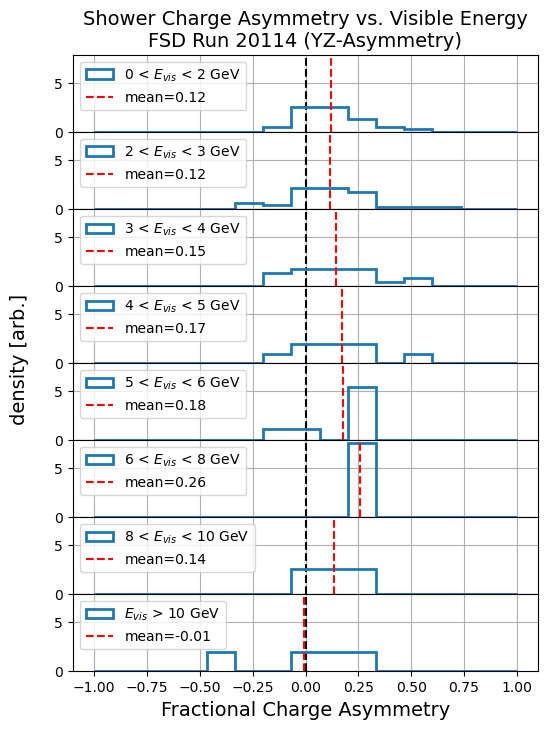

In [14]:

def get_label(mn, mx):
    if mx > 20:
        return '$E_{vis}$ > ' + '{} GeV'.format(mn)
    
    else:
        return '{} '.format(e_bounds[i]) + '< $E_{vis}$ < ' +'{} GeV'.format(e_bounds[i+1]) 

e_bounds=[0, 2, 3, 4, 5, 6, 8, 10, 9999]

fig, axs = plt.subplots(len(e_bounds)-1, 1, figsize=(6, 8), sharex=True, sharey=True)

for i in range(len(e_bounds)-1):
    m = np.logical_and(np.array(sumqs) < e_bounds[i+1], np.array(sumqs) > e_bounds[i])
    ax=axs[i]
    ax.axvline(0, color='black', linestyle='--')
    
    ax.grid()
    lab= get_label(e_bounds[i], e_bounds[i+1])
    ax.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), label=lab, density=True, histtype='step', linewidth=2)
    ax.axvline(np.mean(np.array(q_asymms)[m]), color='red', linestyle='--', label='mean={:0.2f}'.format(np.mean(np.array(q_asymms)[m])))
    ax.legend(loc=2)
fig.supylabel('density [arb.]', fontsize=14)



#plt.yscale('log')
#axs[2].set_ylabel('density', fontsize=14)
axs[0].set_title('Shower Charge Asymmetry vs. Visible Energy\nFSD Run 20114 (YZ-Asymmetry)', fontsize=14)
axs[-1].set_xlabel('Fractional Charge Asymmetry', fontsize=14)
plt.subplots_adjust(wspace=0.0, hspace=0.0)


30


Text(0, 0.5, 'density')

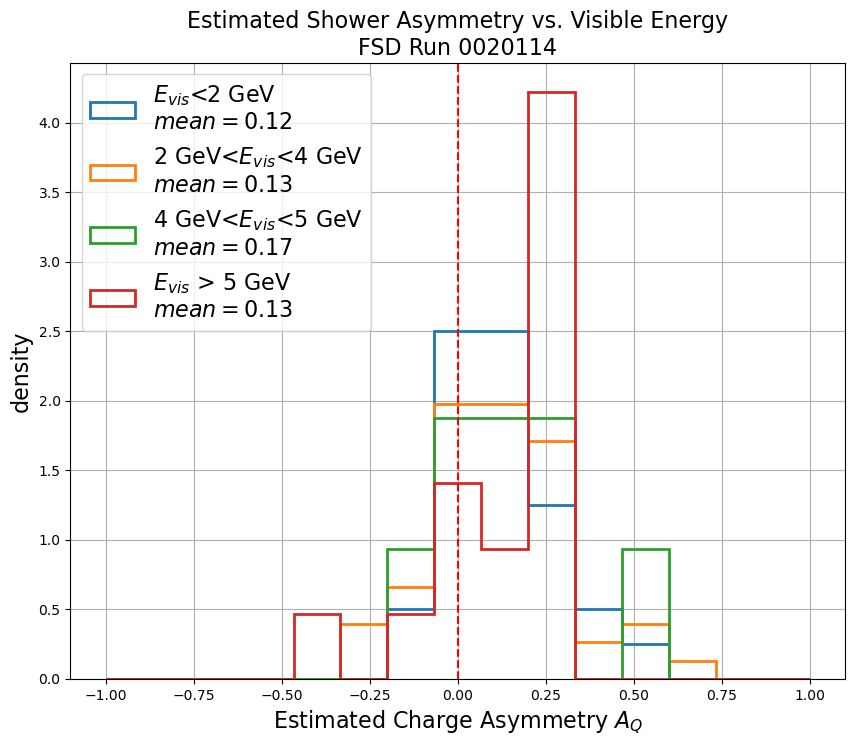

In [15]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot()

m = np.array(sumqs) < 2
print(np.sum(m))
plt.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), density=True, histtype='step', label='$E_{vis}$<2 GeV'+'\n$mean={:0.2f}$'.format(np.mean(np.array(q_asymms)[m])), linewidth=2)

m = np.logical_and(np.array(sumqs) > 2, np.array(sumqs) < 4 ) 
plt.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), density=True, histtype='step', label='2 GeV<$E_{vis}$<4 GeV'+'\n$mean={:0.2f}$'.format(np.mean(np.array(q_asymms)[m])), linewidth=2)


m = np.logical_and(np.array(sumqs) > 4, np.array(sumqs) < 5 ) 
plt.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), density=True, histtype='step', label='4 GeV<$E_{vis}$<5 GeV'+'\n$mean={:0.2f}$'.format(np.mean(np.array(q_asymms)[m])), linewidth=2)

m = np.logical_and(np.array(sumqs) > 5, np.array(sumqs) > 5) 
plt.hist(np.array(q_asymms)[m], bins=15, range=(-1,1), density=True, histtype='step', label='$E_{vis}$ > 5 GeV'+'\n$mean={:0.2f}$'.format(np.mean(np.array(q_asymms)[m])), linewidth=2)


ax.axvline(0, color='red', linestyle='--')
plt.grid()
#plt.yscale('log')
plt.legend(fontsize=16)
ax.set_title('Estimated Shower Asymmetry vs. Visible Energy\nFSD Run 0020114', fontsize=16)
ax.set_xlabel('Estimated Charge Asymmetry $A_Q$', fontsize=16)
ax.set_ylabel('density', fontsize=16)